In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Create a Simple Neural Network

In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Gradient Descent

In [4]:
class GD:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# Momentum

In [5]:
class Momentum:
    def __init__(self, params, lr=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure velocities are on the same device

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.velocity[i] = self.momentum * self.velocity[i] + self.lr * param.grad
                param.data -= self.velocity[i]

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# NAG

In [6]:
class NAG:
    def __init__(self, params, lr=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p, device=device) for p in self.params]

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                # Update velocity with momentum
                self.velocity[i] = self.momentum * self.velocity[i] + self.lr * param.grad
                
                # Update parameters with NAG lookahead
                param.data -= self.lr * param.grad + self.momentum * self.velocity[i]

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# AdaGrad

In [7]:
class AdaGrad:
    def __init__(self, params, lr=0.01, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.epsilon = epsilon
        self.squared_grads = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure squared_grads is on the same device as params

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.squared_grads[i] += param.grad.pow(2)
                param.data -= self.lr * param.grad / (torch.sqrt(self.squared_grads[i]) + self.epsilon)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# AdaDelta

In [8]:
class AdaDelta:
    def __init__(self, params, rho=0.9, epsilon=1e-6):
        self.params = list(params)
        self.rho = rho
        self.epsilon = epsilon
        self.Eg = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure Eg is on the same device as params
        self.Ed = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure Ed is on the same device as params

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.Eg[i] = self.rho * self.Eg[i] + (1 - self.rho) * (param.grad ** 2)
                delta = -(torch.sqrt(self.Ed[i] + self.epsilon) / torch.sqrt(self.Eg[i] + self.epsilon)) * param.grad
                self.Ed[i] = self.rho * self.Ed[i] + (1 - self.rho) * (delta ** 2)
                param.data += delta

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# RMSProp

In [9]:
class RMSProp:
    def __init__(self, params, lr=0.01, alpha=0.99, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.epsilon = epsilon
        self.squared_grads = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure squared_grads is on the same device as params

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.squared_grads[i] = self.alpha * self.squared_grads[i] + (1 - self.alpha) * (param.grad ** 2)
                param.data -= self.lr * param.grad / (torch.sqrt(self.squared_grads[i]) + self.epsilon)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# Adam

In [10]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure m is on the same device as params
        self.v = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure v is on the same device as params
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (param.grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# AdaMax

In [11]:
class AdaMax:
    def __init__(self, params, lr=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure m is on the same device as params
        self.u = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure u is on the same device as params
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
                self.u[i] = torch.max(self.beta2 * self.u[i], torch.abs(param.grad))
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                param.data -= self.lr * m_hat / (self.u[i] + self.epsilon)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# NADAM

In [12]:
class NAdam:
    def __init__(self, params, lr=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure m is on the same device as params
        self.v = [torch.zeros_like(p, device=device) for p in self.params]  # Ensure v is on the same device as params
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (param.grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                param.data -= self.lr * (self.beta1 * m_hat + (1 - self.beta1) * param.grad / (1 - self.beta1 ** self.t)) / (torch.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# AMSGrad

In [13]:
class AMSGrad:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p, device=device) for p in self.params]  # First moment estimate
        self.v = [torch.zeros_like(p, device=device) for p in self.params]  # Second moment estimate
        self.v_hat = [torch.zeros_like(p, device=device) for p in self.params]  # Maintains the maximum of all v's

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is not None:
                # Update biased first moment estimate
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
                # Update biased second raw moment estimate
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (param.grad ** 2)
                # Maintain the maximum of all second raw moment estimates
                self.v_hat[i] = torch.max(self.v_hat[i], self.v[i])
                # Compute the effective learning rate
                step_size = self.lr / (torch.sqrt(self.v_hat[i]) + self.epsilon)
                # Update parameters
                param.data -= step_size * self.m[i]

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# Training & Testing

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [15]:
def train_model(model, optimizer, criterion, train_loader, epochs=10):
    model.to(device)
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
    return losses

def test_model(model, test_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()
model = SimpleNN()

In [17]:
def plot_losses(losses, title):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Batch Gradient Descent:
Epoch [1/10], Loss: 1.0541
Epoch [2/10], Loss: 0.3872
Epoch [3/10], Loss: 0.3300
Epoch [4/10], Loss: 0.2991
Epoch [5/10], Loss: 0.2731
Epoch [6/10], Loss: 0.2507
Epoch [7/10], Loss: 0.2288
Epoch [8/10], Loss: 0.2099
Epoch [9/10], Loss: 0.1935
Epoch [10/10], Loss: 0.1783
Accuracy: 94.80%


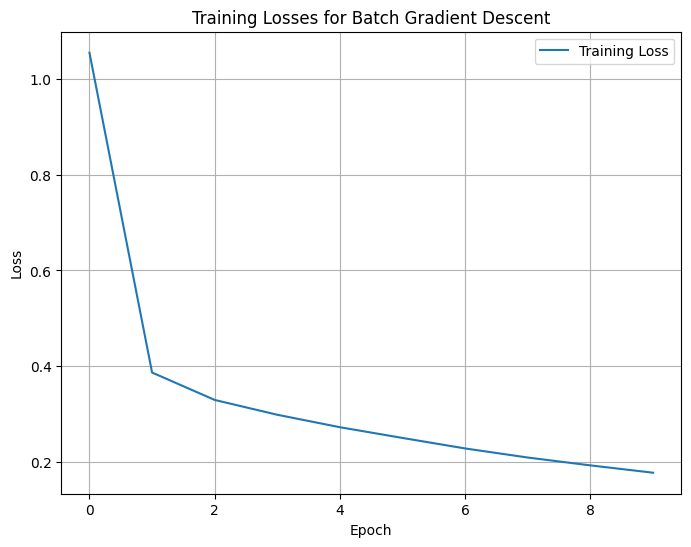

In [18]:
# Batch Gradient Descent
optimizer = GD(model.parameters(), lr=0.01)
print("Batch Gradient Descent:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for Batch Gradient Descent')

Stochastic Gradient Descent:
Epoch [1/10], Loss: 0.3165
Epoch [2/10], Loss: 0.2060
Epoch [3/10], Loss: 0.1719
Epoch [4/10], Loss: 0.1543
Epoch [5/10], Loss: 0.1457
Epoch [6/10], Loss: 0.1367
Epoch [7/10], Loss: 0.1258
Epoch [8/10], Loss: 0.1229
Epoch [9/10], Loss: 0.1098
Epoch [10/10], Loss: 0.1112
Accuracy: 96.63%


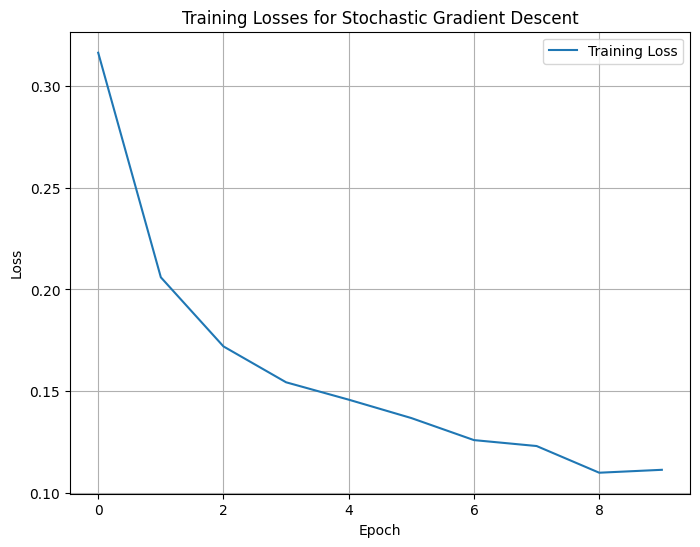

In [19]:
# Stochastic Gradient Descent
optimizer = GD(model.parameters(), lr=0.01)
print("Stochastic Gradient Descent:")
losses = train_model(model, optimizer, criterion, DataLoader(train_set, batch_size=1, shuffle=True))
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for Stochastic Gradient Descent')

Mini-batch Gradient Descent:
Epoch [1/10], Loss: 0.0532
Epoch [2/10], Loss: 0.0396
Epoch [3/10], Loss: 0.0353
Epoch [4/10], Loss: 0.0327
Epoch [5/10], Loss: 0.0307
Epoch [6/10], Loss: 0.0292
Epoch [7/10], Loss: 0.0278
Epoch [8/10], Loss: 0.0267
Epoch [9/10], Loss: 0.0256
Epoch [10/10], Loss: 0.0247
Accuracy: 97.79%


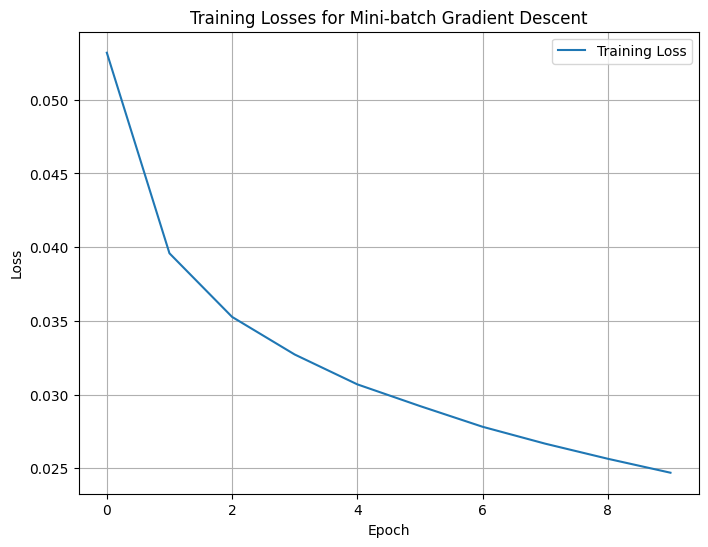

In [20]:
# Mini-batch Gradient Descent
optimizer = GD(model.parameters(), lr=0.01)
print("Mini-batch Gradient Descent:")
losses = train_model(model, optimizer, criterion, DataLoader(train_set, batch_size=32, shuffle=True))
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for Mini-batch Gradient Descent')

Momentum:
Epoch [1/10], Loss: 0.0266
Epoch [2/10], Loss: 0.0235
Epoch [3/10], Loss: 0.0209
Epoch [4/10], Loss: 0.0190
Epoch [5/10], Loss: 0.0171
Epoch [6/10], Loss: 0.0153
Epoch [7/10], Loss: 0.0143
Epoch [8/10], Loss: 0.0128
Epoch [9/10], Loss: 0.0118
Epoch [10/10], Loss: 0.0106
Accuracy: 97.83%


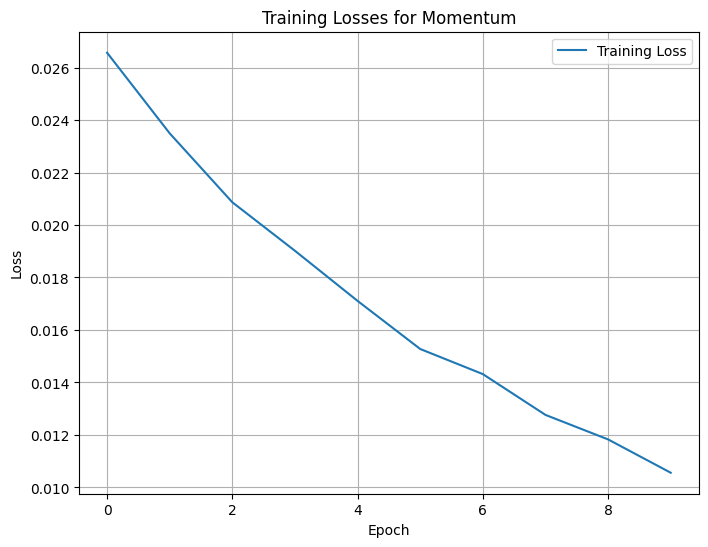

In [21]:
# Momentum
optimizer = Momentum(model.parameters(), lr=0.01, momentum=0.9)
print("Momentum:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for Momentum')

NAG:
Epoch [1/10], Loss: 0.0097
Epoch [2/10], Loss: 0.0091
Epoch [3/10], Loss: 0.0083
Epoch [4/10], Loss: 0.0076
Epoch [5/10], Loss: 0.0068
Epoch [6/10], Loss: 0.0063
Epoch [7/10], Loss: 0.0060
Epoch [8/10], Loss: 0.0053
Epoch [9/10], Loss: 0.0049
Epoch [10/10], Loss: 0.0046
Accuracy: 97.93%


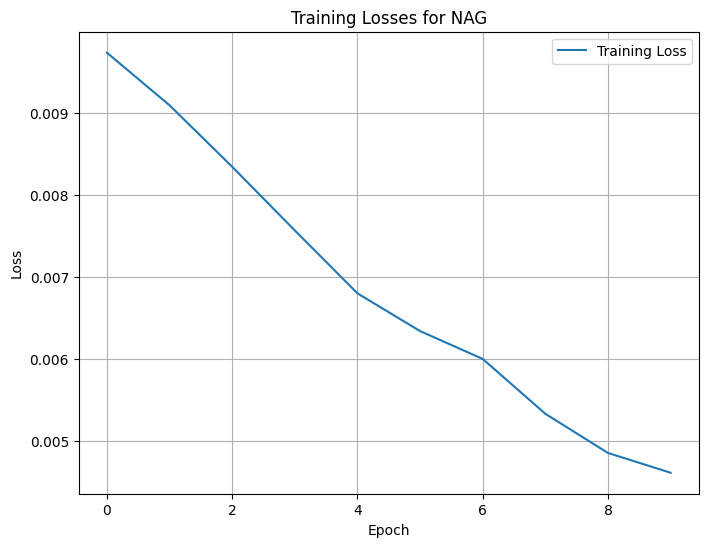

In [22]:
# NAG
optimizer = NAG(model.parameters(), lr=0.01, momentum=0.9)
print("NAG:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for NAG')

AdaGrad:
Epoch [1/10], Loss: 0.0339
Epoch [2/10], Loss: 0.0071
Epoch [3/10], Loss: 0.0048
Epoch [4/10], Loss: 0.0040
Epoch [5/10], Loss: 0.0035
Epoch [6/10], Loss: 0.0031
Epoch [7/10], Loss: 0.0029
Epoch [8/10], Loss: 0.0027
Epoch [9/10], Loss: 0.0025
Epoch [10/10], Loss: 0.0024
Accuracy: 97.97%


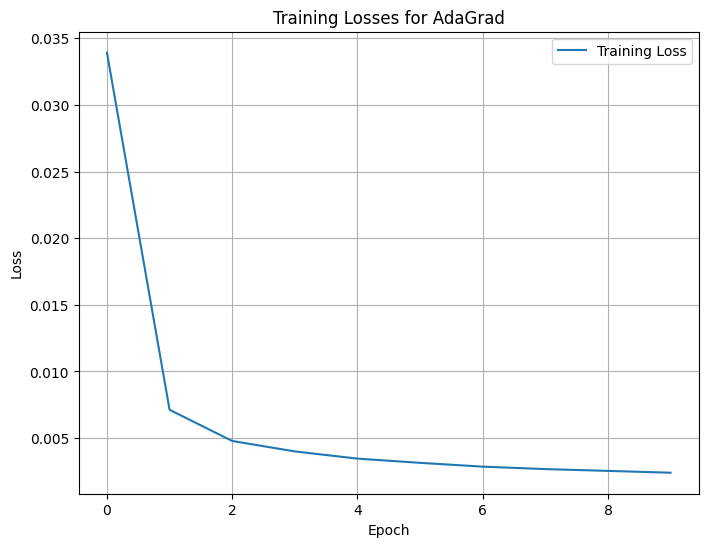

In [23]:
# AdaGrad
optimizer = AdaGrad(model.parameters(), lr=0.01)
print("AdaGrad:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for AdaGrad')

AdaDelta:
Epoch [1/10], Loss: 0.0279
Epoch [2/10], Loss: 0.0259
Epoch [3/10], Loss: 0.0227
Epoch [4/10], Loss: 0.0188
Epoch [5/10], Loss: 0.0199
Epoch [6/10], Loss: 0.0188
Epoch [7/10], Loss: 0.0149
Epoch [8/10], Loss: 0.0152
Epoch [9/10], Loss: 0.0123
Epoch [10/10], Loss: 0.0132
Accuracy: 97.77%


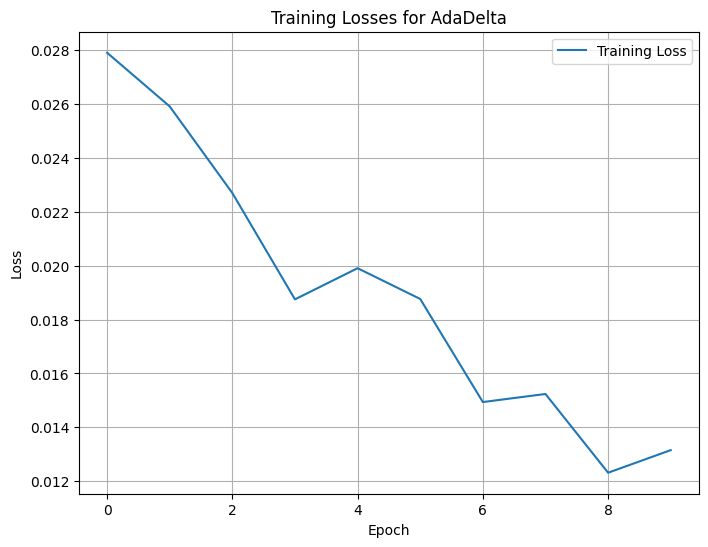

In [24]:
# AdaDelta
optimizer = AdaDelta(model.parameters())
print("AdaDelta:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for AdaDelta')

RMSProp:
Epoch [1/10], Loss: 3.4947
Epoch [2/10], Loss: 2.3020
Epoch [3/10], Loss: 2.3022
Epoch [4/10], Loss: 2.3022
Epoch [5/10], Loss: 2.3022
Epoch [6/10], Loss: 2.3022
Epoch [7/10], Loss: 2.3022
Epoch [8/10], Loss: 2.3022
Epoch [9/10], Loss: 2.3021
Epoch [10/10], Loss: 2.3022
Accuracy: 9.82%


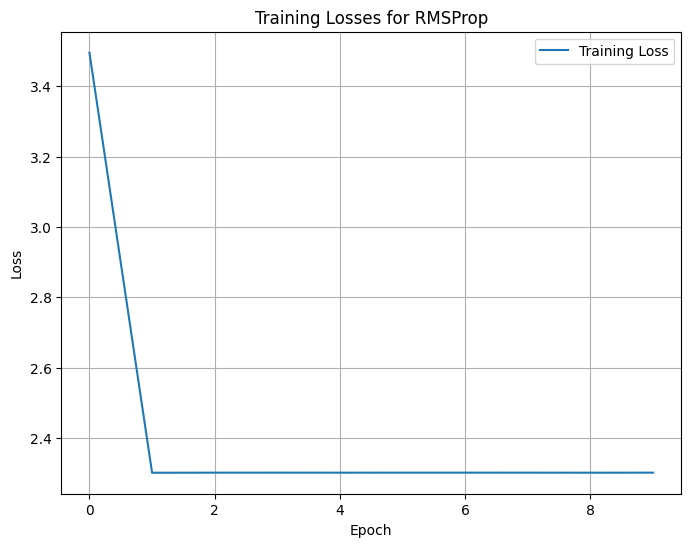

In [25]:
# RMSProp
optimizer = RMSProp(model.parameters(), lr=0.01)
print("RMSProp:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for RMSProp')

Adam:
Epoch [1/10], Loss: 2.3015
Epoch [2/10], Loss: 2.3013
Epoch [3/10], Loss: 2.3013
Epoch [4/10], Loss: 2.3013
Epoch [5/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [8/10], Loss: 2.3013
Epoch [9/10], Loss: 2.3013
Epoch [10/10], Loss: 2.3013
Accuracy: 11.35%


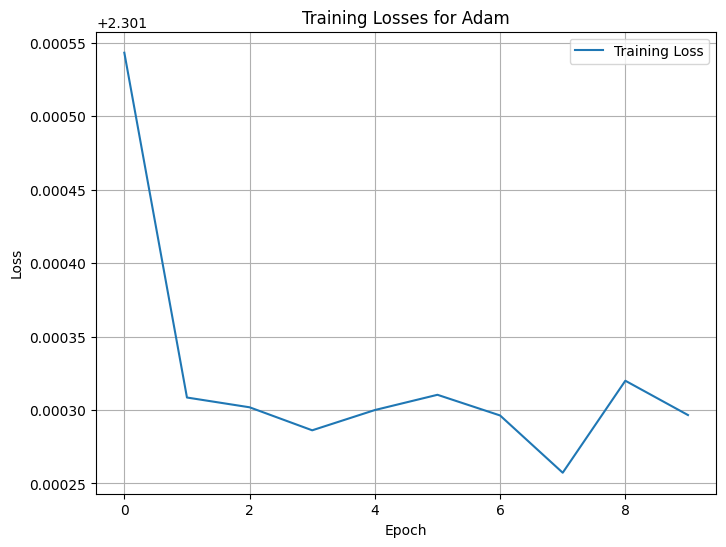

In [26]:
# Adam
optimizer = Adam(model.parameters(), lr=0.001)
print("Adam:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for Adam')

AdaMax:
Epoch [1/10], Loss: 2.3012
Epoch [2/10], Loss: 2.3012
Epoch [3/10], Loss: 2.3012
Epoch [4/10], Loss: 2.3012
Epoch [5/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [7/10], Loss: 2.3012
Epoch [8/10], Loss: 2.3012
Epoch [9/10], Loss: 2.3012
Epoch [10/10], Loss: 2.3012
Accuracy: 11.35%


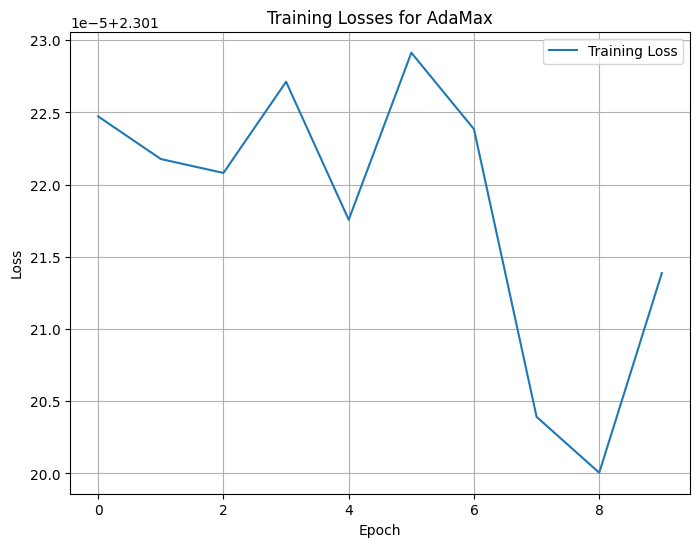

In [27]:
# AdaMax
optimizer = AdaMax(model.parameters(), lr=0.001)
print("AdaMax:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for AdaMax')

NADAM:
Epoch [1/10], Loss: 2.3013
Epoch [2/10], Loss: 2.3013
Epoch [3/10], Loss: 2.3013
Epoch [4/10], Loss: 2.3013
Epoch [5/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [8/10], Loss: 2.3013
Epoch [9/10], Loss: 2.3013
Epoch [10/10], Loss: 2.3013
Accuracy: 11.35%


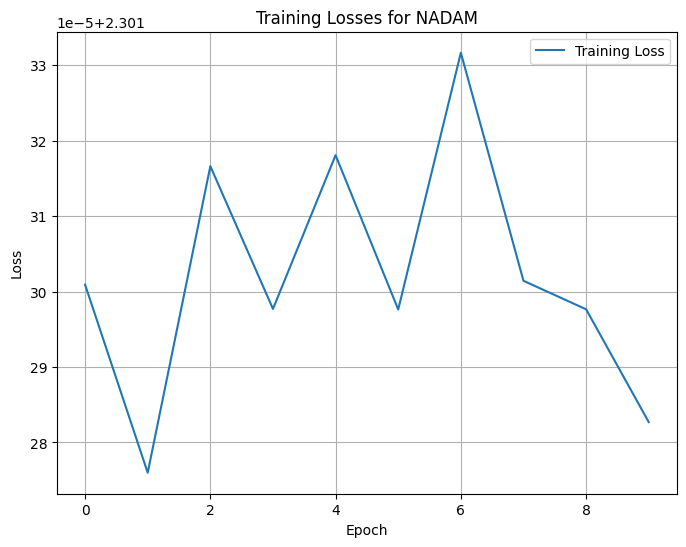

In [28]:
# NADAM
optimizer = NAdam(model.parameters(), lr=0.001)
print("NADAM:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for NADAM')

AMSGrad:
Epoch [1/10], Loss: 2.3015
Epoch [2/10], Loss: 2.3013
Epoch [3/10], Loss: 2.3013
Epoch [4/10], Loss: 2.3013
Epoch [5/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [8/10], Loss: 2.3013
Epoch [9/10], Loss: 2.3013
Epoch [10/10], Loss: 2.3013
Accuracy: 11.35%


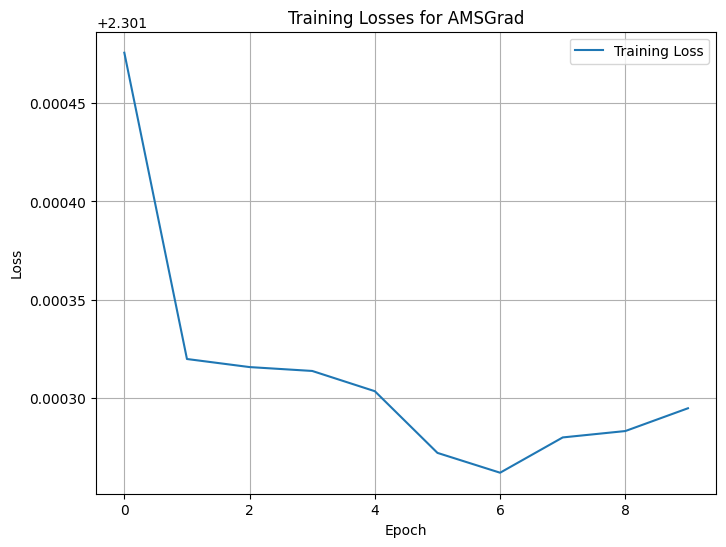

In [29]:
# AMSGrad
optimizer = AMSGrad(model.parameters(), lr=0.001)
print("AMSGrad:")
losses = train_model(model, optimizer, criterion, train_loader)
test_model(model, test_loader)
plot_losses(losses, 'Training Losses for AMSGrad')